In [2]:
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
#import imutils
import pytesseract
import easyocr

In [4]:
def detect_plate(image, debug=False):
    # Passem la imatge a escala de grisos (?)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Fem un closing -> dilatar + erosionar
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed_image = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations = 2)

    # Fem la operació morfològica de "Black Hat" ->  difference between the closing and the given image
    blackHat_image = closed_image - gray

    # Fem closing a la imatge resultant del "Black Hat"
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (45, 1))
    closed_image2 = cv2.morphologyEx(blackHat_image, cv2.MORPH_CLOSE, kernel, iterations = 1)

    # Fem opening -> erosionar + dilatar
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 35))
    open_image = cv2.morphologyEx(closed_image2, cv2.MORPH_OPEN, kernel, iterations = 1)
    hist1 = np.histogram(open_image.flatten())

    # Binaritzem la imatge mitjançant la operació de thresholding (definim un threshold de 80)
    _, binary_image = cv2.threshold(open_image, 30, 255, cv2.THRESH_BINARY)

    # Erosionem i dilatem per eliminar elements/soroll de la imatge binaritzada
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    rem_elem_image = cv2.erode(binary_image, kernel, iterations=3)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    eroded_image = cv2.dilate(rem_elem_image, kernel, iterations=3)

    # De la imatge resultant obtenim el elements (per segmentar la licence plate) amb l'algoritme de Connected Component Labeling
    totalLabels, labelsInfo, stats, centroids = cv2.connectedComponentsWithStats(eroded_image, 8, cv2.CV_32S)

    # Iterem per tots els elemnts trobats i ens quedem amb la bbox de la licence plate
    # AIXÒ S'HA D'ARREGLAR PERQUÈ HO FACI BÉ!!!!!! (LA PART DE LA CONDICIÓ PRINCIPALMENT)
    x_roi, y_roi, w_roi, h_roi = (0, 0, 1, 1)
    for label in range(1, totalLabels):
        x, y, w, h, _ = stats[label]
        if 2 < w/h < 5:
            # Dibuixem un bbox a la imatge i guardem la info de les coordenades
            cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)  # (0, 255, 0) is the color of the rectangle (green), 2 is the line thickness
            x_roi, y_roi, w_roi, h_roi = x, y, w, h


    
    if debug == True:
        plt.imshow(image, cmap='gray')
        plt.show()
        # cv2imshow(image)
        # cv2.waitKey(0)

        plt.imshow(gray, cmap='gray')
        plt.show()
        # cv2_imshow(gray)
        # cv2.waitKey(0)

        plt.imshow(closed_image, cmap='gray')
        plt.show()
        # cv2_imshow(closed_image)
        # cv2.waitKey(0)

        plt.imshow(blackHat_image, cmap='gray')
        plt.show()
        # cv2_imshow(blackHat_image)
        # cv2.waitKey(0)

        plt.imshow(closed_image2, cmap='gray')
        plt.show()
        # cv2_imshow(closed_image2)
        # cv2.waitKey(0)

        plt.imshow(open_image, cmap='gray') 
        plt.show()
        # cv2_imshow(open_image)
        # cv2.waitKey(0)

        plt.hist(hist1)
        plt.show()

        plt.imshow(binary_image, cmap='gray')
        plt.show()
        # cv2_imshow(binary_image)
        # cv2.waitKey(0)

        # cv2_imshow(image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        print(x_roi, y_roi, w_roi, h_roi)
    return x_roi, y_roi, w_roi, h_roi


print(detect_plate("fotos/PXL_20230914_110757610.jpg", debug=False))

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


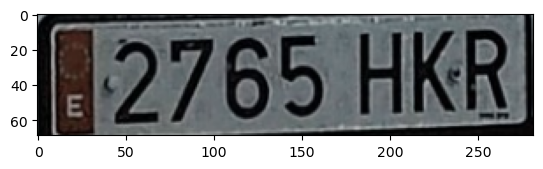

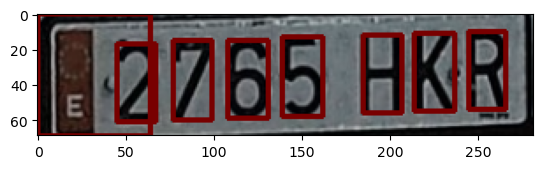

pytesseract diu q la matircula és:87165HKRI

easyocr diu q la matircula és:[([[135, 5], [275, 5], [275, 65], [135, 65]], '6 BRR', 0.5741143491453903)]


In [3]:
import cv2

def segmentChars(roi):

    # Passem la imatge a gris
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # Fem "Black hat"
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
    closed_roi = cv2.morphologyEx(roi_gray, cv2.MORPH_CLOSE, kernel, iterations = 5)
    blackHat_roi = closed_roi - roi_gray

    # Binaritzem la imatge amb thresholding
    _, binary_roi = cv2.threshold(blackHat_roi, 120, 255, cv2.THRESH_BINARY)

    # Trobem els elements a segmentar
    totalLabels_roi, labelsInfo_roi, stats_roi, centroids_roo = cv2.connectedComponentsWithStats(binary_roi, 8, cv2.CV_32S)

    letters_bboxes = []
    for label in range(1, totalLabels_roi):
        x, y, w, h, _ = stats_roi[label]
        if h > 15 and w > 15 and (w < roi.shape[1]/3):
            cv2.rectangle(roi, (x, y), (x + w, y + h), (120, 0, 0), 2)
            letters_bboxes.append((x,y,w,h))

    plt.imshow(roi, cmap='gray')
    plt.show()
    # cv2_imshow(roi)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return letters_bboxes

# path_org = "fotos/bpk2.jpg"
path_org = "fotos/cotxe2.jpg"
img_org = cv2.imread(path_org)
image = cv2.resize(img_org, (1000, 800))
y,x,_ = image.shape
image = image[int(1/3*y):, int(1/3*x):]
# x_roi, y_roi, w_roi, h_roi = (201, 161, 283, 78)
x_roi, y_roi, w_roi, h_roi = detect_plate(path_org)
roi = image[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

plt.imshow(roi, cmap='gray')
plt.show()
# cv2_imshow(roi)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

segmentChars(roi)

print(f"pytesseract diu q la matircula és:{pytesseract.image_to_string(roi, config='--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')}")
reader = easyocr.Reader(['en'])

print(f"easyocr diu q la matircula és:{reader.readtext(roi)}")

In [4]:
def img2str(roi, ocr: str):
    if ocr == "tesseract":
        return pytesseract.image_to_string(roi, config='--psm 8 --oem 3 -c tessedit_char_whitelist=BCDFGHJKLMNPQRSTVWXYZ0123456789 --user-patterns xxx.patterns')
    elif ocr == "easyocr":
        reader = easyocr.Reader(['en'])
        return reader.readtext(roi)
    else:
        print("El ocr ha de ser o bé tesseract o be easyocr")
        return None

In [9]:
def roi_transforms(roi):
    # Image resizing
    resize_test_license_plate = cv2.resize(
    roi, None, fx = 2, fy = 2, 
    interpolation = cv2.INTER_CUBIC)

    # Converting to gray
    grayscale_resize_test_license_plate = cv2.cvtColor(
    resize_test_license_plate, cv2.COLOR_BGR2GRAY)

    # Denoising the image
    gaussian_blur_license_plate = cv2.GaussianBlur(
    grayscale_resize_test_license_plate, (5, 5), 0)

    return gaussian_blur_license_plate

In [10]:
def show(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [25]:
# from plateDetection_pipeline import detect_plate
def plate_reader(img_path: str, ocr: str, debug=False):
    # This function will read the plate from an image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (1000, 800))
    y,x,_ = img.shape
    # img = cv2.resize(img, (1000, 800))
    img_crop = img[int(1/3*y):, int(1/3*x):]
    x_roi, y_roi, w_roi, h_roi = detect_plate(img_crop)
    roi = img[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
    roi_trans = roi_transforms(roi)
    show(img)
    show(img_crop)
    show(roi)
    show(roi_trans)
    return img2str(roi, ocr)

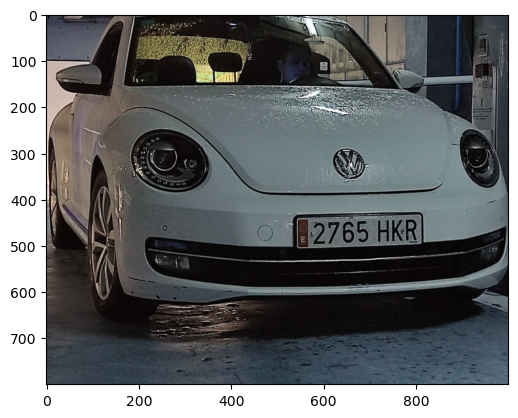

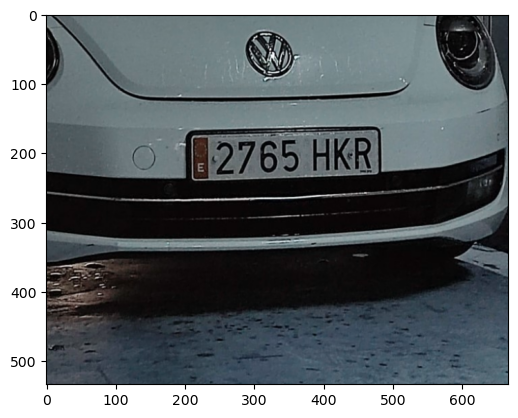

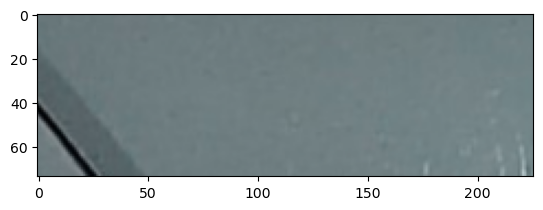

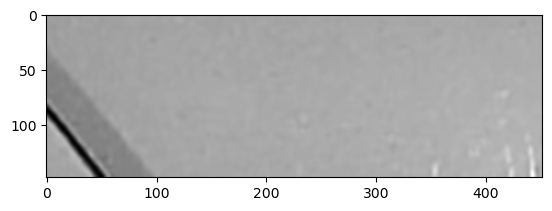

In [26]:
print(plate_reader("fotos/cotxe2.jpg", "tesseract"))

In [4]:
img = cv2.imread(r"/content/cotxe5.jpg")
y,x,_ = img.shape
crop_img = img[int(1/3*y):, int(1/3*x):]

cv2_imshow(crop_img)
cv2.waitKey(0)

AttributeError: 'NoneType' object has no attribute 'shape'